In [1]:
from tqdm import tqdm
import multiprocessing as mlp
import time
import pickle
import swifter
import lightgbm as lgb
import seaborn as sns
from random import seed
import os
import gc
import sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import time, datetime
import pdb, traceback
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle

/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/weiqiang/anaconda3/lib/python

# train test

In [2]:
train_df = pd.read_csv("./dataset/lgb_train_fe_user.csv")
test_df = pd.read_csv("./dataset/lgb_test_fe_user.csv")

In [3]:
train_df.head()

,Id_y,Target,day_len_max,day_len_min,day_len_mean,day_len_ptp,day_len_std,day_len_median,one_num_max,one_num_min,one_num_mean,one_num_ptp,one_num_std,one_num_median,numOlen_max,numOlen_min,numOlen_mean,numOlen_ptp,numOlen_std,numOlen_median
0,../data/train_part/0/193260_002.txt,1,122.0,2.0,9.758621,120.0,18.809979,3.0,1315.0,2.0,48.287356,1313.0,175.492143,8.0,15.114943,1.0,2.783275,14.114943,2.399258,2.000000
1,../data/train_part/0/124280_007.txt,6,176.0,2.0,17.981974,174.0,33.655164,4.0,3525.0,2.0,135.031760,3523.0,343.770422,15.0,20.125000,1.0,4.766268,19.125000,3.936084,3.333333
2,../data/train_part/0/393290_008.txt,7,146.0,2.0,10.384896,144.0,19.486969,3.0,1541.0,2.0,52.500000,1539.0,142.242355,9.0,22.500000,1.0,3.620208,21.500000,3.037970,2.500000
3,../data/train_part/0/212900_008.txt,7,105.0,2.0,9.770751,103.0,12.816230,5.0,758.0,2.0,24.879447,756.0,61.286111,8.0,16.100000,1.0,2.063005,15.100000,1.695594,1.500000
4,../data/train_part/0/154600_005.txt,4,11.0,2.0,6.666667,9.0,3.681787,7.0,18.0,2.0,9.666667,16.0,6.548961,9.0,1.636364,1.0,1.307359,0.636364,0.260245,1.285714


In [4]:
trains = pd.read_csv("./dataset/lgb_train_fe.csv")
tests = pd.read_csv("./dataset/lgb_test_fe.csv")

/home/weiqiang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/weiqiang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/weiqiang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


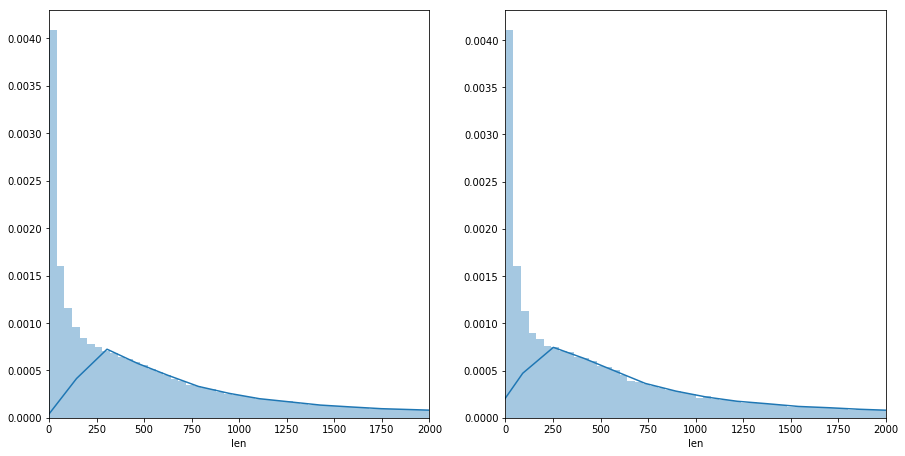

In [61]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,2,1)
sns.distplot(trains.loc[(trains.len<20000), "len"], bins=500)
plt.xlim(0, 2000)
plt.subplot(1,2,2)
sns.distplot(tests.loc[(tests.len<20000), "len"], bins=500)
plt.xlim(0, 2000)
plt.show()

/home/weiqiang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/weiqiang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/weiqiang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


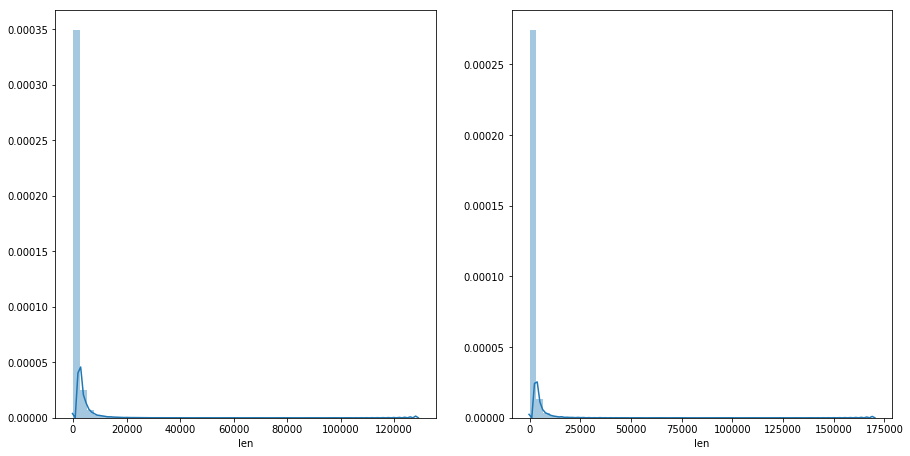

In [19]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,2,1)
sns.distplot(trains.len)
plt.subplot(1,2,2)
sns.distplot(tests.len)
plt.show()

/home/weiqiang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/weiqiang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/weiqiang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


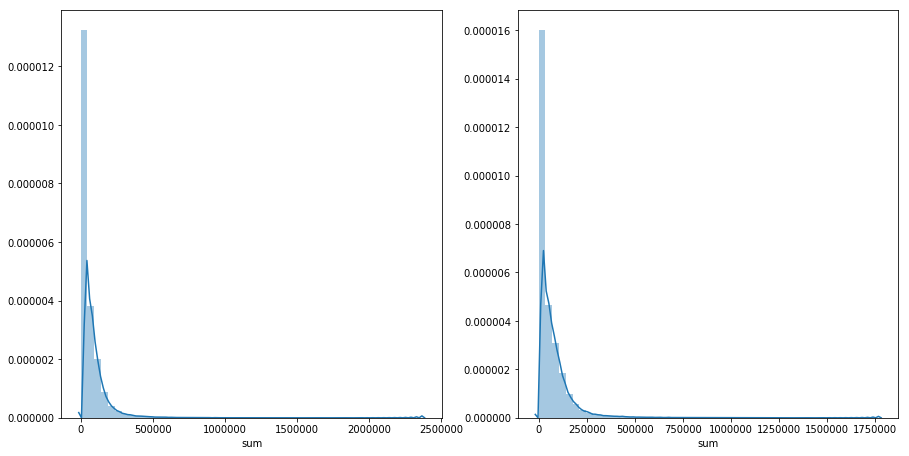

In [20]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,2,1)
sns.distplot(trains["sum"])
plt.subplot(1,2,2)
sns.distplot(tests["sum"])
plt.show()

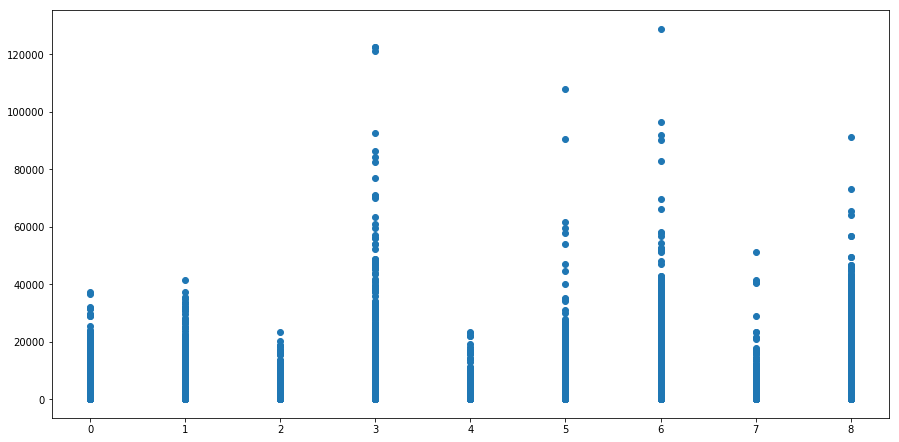

In [69]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,1,1)
plt.scatter(train_df.Target, trains["len"])
# plt.subplot(1,2,2)
# sns.distplot(tests["sum"])
plt.show()

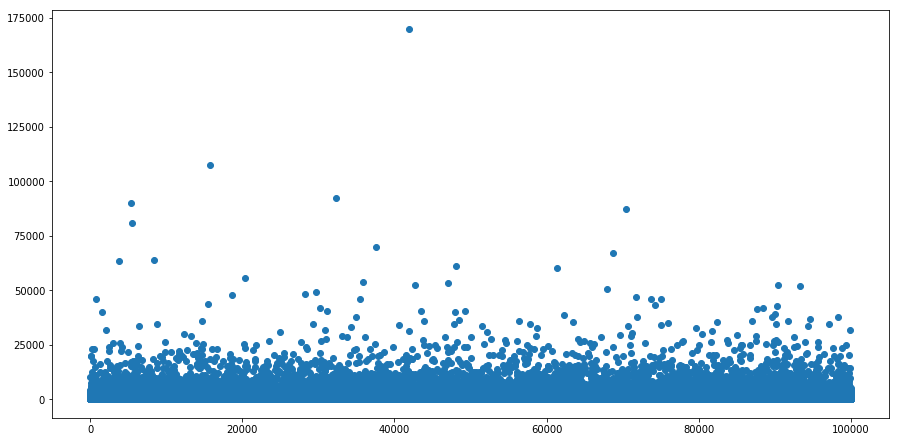

In [70]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,1,1)
plt.scatter(range(100000), tests["len"])
# plt.subplot(1,2,2)
# sns.distplot(tests["sum"])
plt.show()

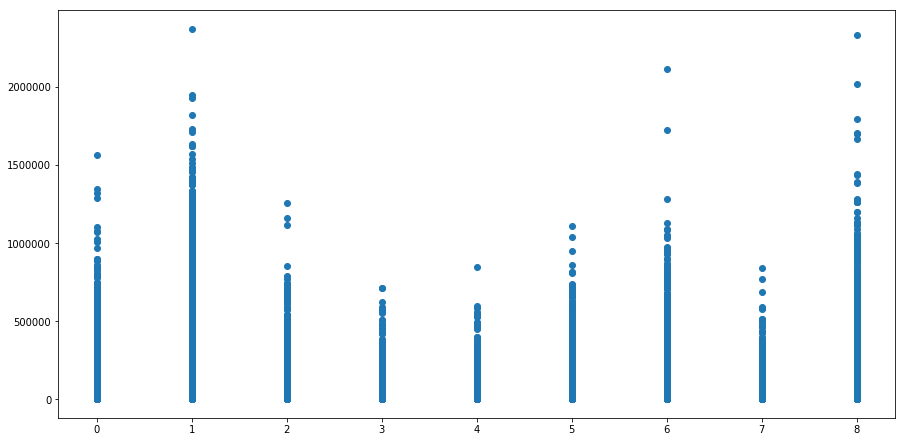

In [64]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,1,1)
plt.scatter(train_df.Target, trains["sum"])
# plt.subplot(1,2,2)
# sns.distplot(tests["sum"])
plt.show()

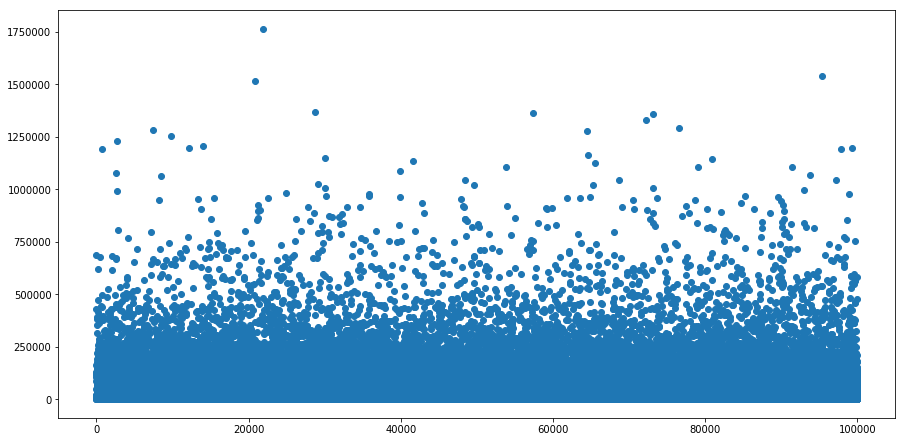

In [68]:
plt.figure(figsize=(15, 7.5))
plt.subplot(1,1,1)
plt.scatter(range(100000), tests["sum"])
# plt.subplot(1,2,2)
# sns.distplot(tests["sum"])
plt.show()

In [26]:
trains["len"].value_counts()

1        6890
2        4771
3        3920
4        3168
5        2770
6        2452
7        2232
8        2019
9        1920
10       1788
11       1695
13       1632
12       1592
15       1484
14       1469
16       1380
17       1347
18       1277
20       1273
21       1216
19       1172
22       1100
24       1086
26       1048
29       1045
25       1034
23       1031
27        991
31        983
28        937
         ... 
11656       1
13285       1
29058       1
25216       1
9785        1
17284       1
27777       1
10742       1
11401       1
7311        1
7648        1
5518        1
13371       1
6974        1
23032       1
8329        1
6896        1
12427       1
10632       1
6462        1
8585        1
10888       1
8841        1
12939       1
21383       1
11144       1
11238       1
13451       1
7743        1
14545       1
Name: len, Length: 12033, dtype: int64

In [52]:
tests["len"].value_counts().value_counts()

1      2723
2      1046
3       567
4       383
5       284
6       210
7       184
8       142
9       131
10      105
11       95
12       88
13       70
15       68
14       61
16       58
17       48
19       48
21       46
20       41
18       33
22       32
24       30
23       28
26       24
27       23
29       22
25       22
30       22
34       22
       ... 
194       1
101       1
233       1
109       1
121       1
125       1
129       1
145       1
149       1
153       1
169       1
181       1
185       1
217       1
225       1
237       1
166       1
241       1
245       1
383       1
301       1
385       1
98        1
102       1
106       1
122       1
134       1
150       1
158       1
273       1
Name: len, Length: 198, dtype: int64

In [57]:
trains.loc[trains.Target==0, "len"].value_counts()

1        287
2        254
3        243
4        205
5        200
6        196
7        192
9        180
14       180
12       165
20       155
10       155
13       154
33       153
16       152
8        151
11       149
29       149
348      148
15       146
52       144
17       144
25       139
31       139
22       138
40       136
28       136
47       134
330      134
19       134
        ... 
7349       1
4629       1
6612       1
16799      1
5364       1
5428       1
8467       1
6356       1
5077       1
9363       1
4660       1
5333       1
4122       1
6709       1
4054       1
6101       1
8148       1
3926       1
14097      1
5845       1
5781       1
3670       1
5717       1
9811       1
6837       1
5653       1
5397       1
7444       1
4916       1
5405       1
Name: len, Length: 6627, dtype: int64

In [38]:
trains.loc[trains.Target==8, "len"].value_counts()

1        22
16       22
9        21
13       19
19       18
8        18
11       18
7        18
15       18
43       18
6        17
680      17
31       16
3        16
67       16
28       16
1227     16
304      16
41       16
123      15
55       15
90       15
561      15
5        15
33       15
21       15
4        15
803      14
29       14
339      14
         ..
11232     1
5079      1
3028      1
9169      1
11216     1
4889      1
6936      1
8959      1
8847      1
14956     1
23152     1
9409      1
4729      1
13491     1
9393      1
5287      1
7334      1
2698      1
10926     1
2810      1
6840      1
2746      1
9345      1
2762      1
15474     1
19170     1
2794      1
3156      1
13395     1
4094      1
Name: len, Length: 6394, dtype: int64

In [55]:
trains.loc[trains.len==1, "sum"].value_counts()

3.0       834
2.0       800
4.0       577
5.0       385
6.0       313
7.0       298
8.0       240
10.0      231
9.0       221
11.0      208
12.0      172
13.0      172
15.0      165
14.0      160
16.0      148
18.0      117
17.0      116
19.0      115
23.0       95
20.0       92
22.0       92
21.0       84
26.0       83
25.0       81
24.0       81
28.0       65
27.0       64
31.0       49
30.0       46
29.0       42
         ... 
114.0       1
207.0       1
402.0       1
166.0       1
223.0       1
199.0       1
412.0       1
125.0       1
278.0       1
111.0       1
682.0       1
303.0       1
318.0       1
246.0       1
252.0       1
93.0        1
1287.0      1
178.0       1
478.0       1
286.0       1
237.0       1
279.0       1
255.0       1
330.0       1
80.0        1
320.0       1
160.0       1
220.0       1
206.0       1
88.0        1
Name: sum, Length: 181, dtype: int64

In [13]:
trains["sum"].value_counts()

3.0         834
2.0         800
4.0         664
5.0         518
7.0         494
6.0         482
10.0        445
8.0         442
9.0         437
12.0        410
13.0        407
15.0        406
11.0        391
16.0        389
18.0        377
14.0        372
23.0        364
26.0        350
20.0        328
19.0        323
17.0        323
25.0        321
21.0        318
22.0        311
31.0        307
24.0        302
32.0        294
36.0        282
34.0        278
27.0        277
           ... 
196553.0      1
138248.0      1
98277.0       1
49139.0       1
97712.0       1
196557.0      1
59068.0       1
24570.0       1
70140.0       1
49132.0       1
196494.0      1
393052.0      1
181362.0      1
196499.0      1
79340.0       1
97716.0       1
59070.0       1
98253.0       1
70142.0       1
212112.0      1
98258.0       1
597920.0      1
98259.0       1
88536.0       1
196519.0      1
88480.0       1
62644.0       1
98262.0       1
48280.0       1
190578.0      1
Name: sum, Length: 13591

In [3]:
all_files = pd.read_csv("../BaiDuBigData19-URFC/train.csv")
test_files = pd.read_csv("../BaiDuBigData19-URFC/test.csv")

In [4]:
print(len(all_files),len(test_files))

39730 10000


In [5]:
test_files.head()

,Id,Target
0,3132,0
1,798,0
2,1016,0
3,5125,0
4,3994,0


In [6]:
test_files['Id'] = test_files['Id'].swifter.apply(lambda x: str(x).zfill(6))
test_files.head()

Pandas Apply: 100%|██████████| 10000/10000 [00:00<00:00, 309214.12it/s]


,Id,Target
0,003132,0
1,000798,0
2,001016,0
3,005125,0
4,003994,0


In [2]:
train_txt = []
for root, dirs, files in os.walk("../data/train_part/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file.split("_")
        train_txt.append([filePath, CategoryID[:3]])

test_txt = []
for root, dirs, files in os.walk("../data/test_part/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file, "000"
        test_txt.append([filePath, CategoryID[:3]])

In [3]:
all_files = pd.DataFrame(train_txt, columns=["Id_y", "Target"])
all_files.Target = pd.to_numeric(all_files.Target)

test_files = pd.DataFrame(test_txt, columns=["Id_y", "Target"])
test_files.Target = pd.to_numeric(test_files.Target)

In [41]:
train_txt = []
for root, dirs, files in os.walk("../data_old/train_visit/train/", topdown=True):
    for file in files:
        filePath = os.path.join(root, file)
        AreaID, CategoryID = file.split("_")
        train_txt.append([filePath, CategoryID[:3]])

all_files = pd.DataFrame(train_txt, columns=["Id_y", "Target"])
all_files.Target = pd.to_numeric(all_files.Target)

In [7]:
all_files

,Id_y,Target
0,../data/train_part/0/193260_002.txt,2
1,../data/train_part/0/124280_007.txt,7
2,../data/train_part/0/393290_008.txt,8
3,../data/train_part/0/212900_008.txt,8
4,../data/train_part/0/154600_005.txt,5
5,../data/train_part/0/100160_007.txt,7
6,../data/train_part/0/225720_006.txt,6
7,../data/train_part/0/179750_001.txt,1
8,../data/train_part/0/107730_003.txt,3
9,../data/train_part/0/272200_003.txt,3


In [21]:
guoqing_ed = (datetime.datetime.strptime("20181007", '%Y%m%d') - datetime.datetime.strptime("20181001", '%Y%m%d')).days

chunjie_sd = (datetime.datetime.strptime("20190204", '%Y%m%d') - datetime.datetime.strptime("20181001", '%Y%m%d')).days
chunjie_ed = (datetime.datetime.strptime("20190210", '%Y%m%d') - datetime.datetime.strptime("20181001", '%Y%m%d')).days

hanjia_sd = (datetime.datetime.strptime("20190121", '%Y%m%d') - datetime.datetime.strptime("20181001", '%Y%m%d')).days
hanjia_ed = (datetime.datetime.strptime("20190224", '%Y%m%d') - datetime.datetime.strptime("20181001", '%Y%m%d')).days
# 用字典查询代替类型转换，可以减少一部分计算时间
date2position = {}
datestr2dateint = {}
str2int = {}

for i in range(24):
    str2int[str(i).zfill(2)] = i

# 访问记录内的时间从2018年10月1日起，共182天
# 10.1 % 7 == 1
# 将日期按日历排列
for i in range(182):
    date = datetime.date(day=1, month=10, year=2018)+datetime.timedelta(days=i)
    date_int = int(date.__str__().replace("-", ""))
#     date2position[date_int] = date.isoweekday()
    if i in range(guoqing_ed+1):
        date2position[date_int] = ("gq", date.isoweekday())
    elif i in range(hanjia_sd, hanjia_ed+1):
        date2position[date_int] = ("gq", date.isoweekday())
    datestr2dateint[str(date_int)] = date_int

In [22]:
datestr2dateint

{'20181001': 20181001,
 '20181002': 20181002,
 '20181003': 20181003,
 '20181004': 20181004,
 '20181005': 20181005,
 '20181006': 20181006,
 '20181007': 20181007,
 '20181008': 20181008,
 '20181009': 20181009,
 '20181010': 20181010,
 '20181011': 20181011,
 '20181012': 20181012,
 '20181013': 20181013,
 '20181014': 20181014,
 '20181015': 20181015,
 '20181016': 20181016,
 '20181017': 20181017,
 '20181018': 20181018,
 '20181019': 20181019,
 '20181020': 20181020,
 '20181021': 20181021,
 '20181022': 20181022,
 '20181023': 20181023,
 '20181024': 20181024,
 '20181025': 20181025,
 '20181026': 20181026,
 '20181027': 20181027,
 '20181028': 20181028,
 '20181029': 20181029,
 '20181030': 20181030,
 '20181031': 20181031,
 '20181101': 20181101,
 '20181102': 20181102,
 '20181103': 20181103,
 '20181104': 20181104,
 '20181105': 20181105,
 '20181106': 20181106,
 '20181107': 20181107,
 '20181108': 20181108,
 '20181109': 20181109,
 '20181110': 20181110,
 '20181111': 20181111,
 '20181112': 20181112,
 '20181113'

In [23]:
date2position

{20181001: 1,
 20181002: 2,
 20181003: 3,
 20181004: 4,
 20181005: 5,
 20181006: 6,
 20181007: 7,
 20181008: 1,
 20181009: 2,
 20181010: 3,
 20181011: 4,
 20181012: 5,
 20181013: 6,
 20181014: 7,
 20181015: 1,
 20181016: 2,
 20181017: 3,
 20181018: 4,
 20181019: 5,
 20181020: 6,
 20181021: 7,
 20181022: 1,
 20181023: 2,
 20181024: 3,
 20181025: 4,
 20181026: 5,
 20181027: 6,
 20181028: 7,
 20181029: 1,
 20181030: 2,
 20181031: 3,
 20181101: 4,
 20181102: 5,
 20181103: 6,
 20181104: 7,
 20181105: 1,
 20181106: 2,
 20181107: 3,
 20181108: 4,
 20181109: 5,
 20181110: 6,
 20181111: 7,
 20181112: 1,
 20181113: 2,
 20181114: 3,
 20181115: 4,
 20181116: 5,
 20181117: 6,
 20181118: 7,
 20181119: 1,
 20181120: 2,
 20181121: 3,
 20181122: 4,
 20181123: 5,
 20181124: 6,
 20181125: 7,
 20181126: 1,
 20181127: 2,
 20181128: 3,
 20181129: 4,
 20181130: 5,
 20181201: 6,
 20181202: 7,
 20181203: 1,
 20181204: 2,
 20181205: 3,
 20181206: 4,
 20181207: 5,
 20181208: 6,
 20181209: 7,
 20181210: 1,
 20181

In [42]:
train_df = pd.read_csv("./dataset/final_train.csv")
test_df = pd.read_csv("./dataset/final_test.csv")

In [55]:
train_df.head()

,Id_x,Target,black_ratio,basename,Id_v182
0,../data/train/001/000003_001.jpg,0,0.0,000003_001.npy,../data/npy/train_visit/000003_001.pkl
1,../data/train/001/000007_001.jpg,0,0.0,000007_001.npy,../data/npy/train_visit/000007_001.pkl
2,../data/train/001/000008_001.jpg,0,0.0,000008_001.npy,../data/npy/train_visit/000008_001.pkl
3,../data/train/001/000009_001.jpg,0,0.0,000009_001.npy,../data/npy/train_visit/000009_001.pkl
4,../data/train/001/000013_001.jpg,0,0.0,000013_001.npy,../data/npy/train_visit/000013_001.pkl


In [44]:
train_df["basename"] = train_df.Id_y.apply(lambda x:os.path.basename(x).replace("pkl", "npy"))
test_df["basename"] = test_df.Id_y.apply(lambda x:os.path.basename(x).replace("pkl", "npy"))

In [47]:
all_files["basename"] = all_files.Id_y.apply(lambda x:os.path.basename(x).replace("txt", "npy"))
test_files["basename"] = test_files.Id_y.apply(lambda x:os.path.basename(x).replace("txt", "npy"))

In [51]:
train_df.columns = list(train_df.columns[:-1]) + ["Id_v182"]

In [52]:
test_df.columns = list(test_df.columns[:-1]) + ["Id_v182"]

In [63]:
_tr = pd.merge(train_df, all_files, "left", on=["basename", "Target"])

In [62]:
all_files.Target = all_files.Target - 1

In [65]:
_tr.Id_y = _tr.Id_y.apply(lambda x: x.replace("part", "part_decompose").replace("txt", "npy"))

In [71]:
_tr.to_csv("./dataset/final_train.csv", index=False)

In [67]:
_te = pd.merge(test_df, test_files, "left", on=["basename", "Target"])

In [69]:
_te.Id_y = _te.Id_y.apply(lambda x: x.replace("part", "part_decompose").replace("txt", "npy"))

In [72]:
_te.to_csv("./dataset/final_test.csv", index=False)

In [35]:
count = 0
for i in "20181107&18,20181108&17|18,20181112&18,20181123&18,20181214&17,20181228&18".split(","):
    print(i[:8], date2position[datestr2dateint[i[:8]]])
    count += i[9:].count("|")+1

20181107 3
20181108 4
20181112 1
20181123 5
20181214 5
20181228 5


In [48]:
def get_userinfo(x, s_type="train"):
    table = pd.read_csv(x, sep="\t", header=None)
    temp = {}
    temp["weekday_lens"] = []
    temp["endday_lens"] = []
    temp["weekday_num"] = []
    temp["endday_num"] = []
    temp["weekday_numOlens"] = []
    temp["endday_numOlens"] = []
    temp["weekOend_lens"] = []
    temp["weekOend_sum"] = []
    for string in table[1]:
#         u_len = string.count("&")
#         temp["lens"].append(u_len)
        weekday_lens, endday_lens, weekday_num, endday_num = 0, 0, 0, 0
        for item in string.split(','):
            weekorend = date2position[datestr2dateint[item[:8]]]
            if weekorend <= 5:
                weekday_lens += 1
                weekday_num += item[9:].count("|")+1
            else:
                endday_lens += 1
                endday_num += item[9:].count("|")+1
        temp["weekday_lens"].append(weekday_lens)
        temp["endday_lens"].append(endday_lens)
        temp["weekday_num"].append(weekday_num)
        temp["endday_num"].append(endday_num)
        
        temp["weekday_numOlens"].append(weekday_num/(weekday_lens+1e-5))
        temp["endday_numOlens"].append(endday_num/(endday_lens+1e-5))
        temp["weekOend_lens"].append(weekday_lens/(endday_lens+1e-5))
        temp["weekOend_sum"].append(weekday_num/(endday_num+1e-5))
        
    return stat_features(temp["weekday_lens"]) + stat_features(temp["endday_lens"]) + stat_features(temp["weekday_num"]) + \
            stat_features(temp["endday_num"]) + stat_features(temp["weekday_numOlens"]) + stat_features(temp["endday_numOlens"]) + \
            stat_features(temp["weekOend_lens"]) + stat_features(temp["weekOend_sum"])

In [11]:
def get_userinfo(x, fold, s_type="train"):
    uid_counts = np.zeros(10)
    for uid in x:
        for i in range(9):
            if uid in train_uids[fold][i+1]:
                uid_counts[i] = uid_counts[i] + 1
            else:
                uid_counts[9] = uid_counts[9] + 1
    return uid_counts
def multi_task(data, fold, s_type):
    data["uids_count"] =  data['uids'].swifter.apply(lambda x: get_userinfo(x, fold, s_type))
    return data

In [64]:
x = pd.read_csv("../data/test_part/0/000000.txt", sep="\t", header=None)[0].values
get_userinfo_(x)

array([702.,  41.,   2.,   6.,   0.,  34.,  22.,   3.,  55., 182.])

In [68]:
get_userinfo_(x)

array([702., 242.,  28.,  66.,   0., 258., 248.,  70., 386., 182.])

In [67]:
def get_userinfo_(x, s_type="train"):
    uid_counts = np.zeros(10)
    for uid in x:
        c = 0
        for i in range(9):
            if uid in train_uids[i+1]:
                uid_counts[i] = uid_counts[i] + 1
                c += 1
        if c == 0:
            uid_counts[9] = uid_counts[9] + 1
    return uid_counts

In [10]:
def get_userinfo(x, s_type="train"):
    uid_counts = np.zeros(10)
    for uid in x:
        c = 0
        for i in range(9):
            if uid in train_uids[i+1]:
                uid_counts[i] = uid_counts[i] + 1
                c += 1
        if c == 0:
            uid_counts[9] = uid_counts[9] + 1
    return uid_counts
def multi_task(data, s_type):
    data["uids_count"] =  data['uids'].swifter.apply(lambda x: get_userinfo(x, s_type))
    return data

In [8]:
%%timeit
a = set(np.arange(10))
a.update(set(np.arange(10, 15)))

5.58 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [99]:
pd.read_csv(test_files.Id_y[0], sep="\t", header=None)

,0,1
0,2d0963d4afef53ca,"20190319&23,20190320&04|05|06|07|08|09|10|11|1..."
1,45c5830c28a6f83b,"20190319&17|18|19|20|21|22,20190320&10|11|12|1..."
2,85504b06fc91eaf7,"20181003&12,20181007&09"
3,5f1e7128aed6ba95,"20181015&08|09|10|13|14|15|16,20181016&08|09|1..."
4,aca41ded20ad5607,"20181017&14,20181022&07,20181026&09|10|11,2018..."
5,7963b41cfb6fc54b,"20181030&17|19|20|22,20181101&13|18|19|20|21|2..."
6,821b8909667c083c,"20181225&10|16|17,20190221&10|11|12"
7,47eaaa1232b910fe,"20190122&20|21|22|23,20190123&00|01|02|03|04|0..."
8,d539da50577c9f18,"20181002&11,20181003&13,20181009&19,20181010&02"
9,86d999957d0139f9,"20181012&08|09|10|11|12|13|14|15|16,20181014&2..."


In [104]:
len(tests.uids[0])

1018

In [111]:
tests.uids_count[0]

array([452., 786., 191., 133.,  83., 210., 338.,  94., 229., 789.])

In [112]:
tests.drop(columns=features_uids_feature, inplace=True)

In [109]:
get_userinfo(tests.uids[0])

array([452., 786., 191., 133.,  83., 210., 338.,  94., 229., 129.])

In [4]:
def get_userinfo(x, s_type="train"):
    table = pd.read_csv(x, sep="\t", header=None)
    return set(table[0].values)
def multi_task(data, s_type):
    data["uids"] =  data['Id_y'].swifter.apply(lambda x: get_userinfo(x, s_type))
    return data

In [49]:
def stat_features(arr):
    if len(arr) != 0:
        return [max(arr), min(arr), np.mean(arr), np.ptp(arr), np.std(arr), np.median(arr), sum(arr)]
    else:
        return None

In [50]:
def multi_task(data, s_type):
    data["stats"] =  data['Id_y'].swifter.apply(lambda x: get_userinfo(x,s_type))
    return data

In [53]:
get_userinfo(trains.uids[0])

array([48., 87., 11.,  4.,  0.,  4.,  9.,  7., 11.])

Process ForkPoolWorker-107:
Process ForkPoolWorker-111:
Process ForkPoolWorker-109:
Process ForkPoolWorker-110:
Process ForkPoolWorker-108:
Traceback (most recent call last):
  File "/home/weiqiang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/weiqiang/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/weiqiang/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/home/weiqiang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/weiqiang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/weiqiang/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get


In [55]:
trains.uids[0].shape

(87,)

In [12]:
vals_list = []
for fold in range(5):
    val_files = trains.loc[trains.Id_y.isin(lgb_Idy_val[fold])]
    # train
    t0 = time.time()
    N = val_files.shape[0]
    print(N)
    num_cpu = 20 # cpu数量
    pool = mlp.Pool(num_cpu)

    results = []
    batch_num = N // num_cpu
    print('batch_num',batch_num)
    for i in range(num_cpu):
        if i == num_cpu-1:
            offset = N
        else:
            offset = (i+1)*batch_num
        task_train = val_files.iloc[i*batch_num : offset]
        print('task',i,'shape',len(task_train))
        result = pool.apply_async(multi_task,(task_train, fold, 'train',))
        results.append(result)
    pool.close()
    pool.join()
    print('finished',len(results))

    t1 = time.time()
    print('time', int(t1 - t0), 's')
    vals = pd.DataFrame()
    for result in tqdm(results):
        vals = pd.concat([vals, result.get()])
    print(vals.shape[0])
    vals_list.append(vals)

80002
batch_num 4000
task 0 shape 4000
task 1 shape 4000
task 2 shape 4000
task 3 shape 4000
task 4 shape 4000
task 5 shape 4000
task 6 shape 4000
task 7 shape 4000
task 8 shape 4000
task 9 shape 4000
task 10 shape 4000
task 11 shape 4000
task 12 shape 4000
task 13 shape 4000
task 14 shape 4000
task 15 shape 4000
task 16 shape 4000
task 17 shape 4000
task 18 shape 4000
task 19 shape 4002


 60%|██████    | 12/20 [00:00<00:00, 104.51it/s]

finished 20
time 1467 s


100%|██████████| 20/20 [00:00<00:00, 68.91it/s] 


80002
80001
batch_num 4000
task 0 shape 4000
task 1 shape 4000
task 2 shape 4000
task 3 shape 4000
task 4 shape 4000
task 5 shape 4000
task 6 shape 4000
task 7 shape 4000
task 8 shape 4000
task 9 shape 4000
task 10 shape 4000
task 11 shape 4000
task 12 shape 4000
task 13 shape 4000
task 14 shape 4000
task 15 shape 4000
task 16 shape 4000
task 17 shape 4000
task 18 shape 4000
task 19 shape 4001


 60%|██████    | 12/20 [00:00<00:00, 114.57it/s]

finished 20
time 521 s


100%|██████████| 20/20 [00:00<00:00, 63.14it/s] 


80001
80001
batch_num 4000
task 0 shape 4000
task 1 shape 4000
task 2 shape 4000
task 3 shape 4000
task 4 shape 4000
task 5 shape 4000
task 6 shape 4000
task 7 shape 4000
task 8 shape 4000
task 9 shape 4000
task 10 shape 4000
task 11 shape 4000
task 12 shape 4000
task 13 shape 4000
task 14 shape 4000
task 15 shape 4000
task 16 shape 4000
task 17 shape 4000
task 18 shape 4000
task 19 shape 4001


 65%|██████▌   | 13/20 [00:00<00:00, 122.49it/s]

finished 20
time 592 s


100%|██████████| 20/20 [00:00<00:00, 93.83it/s] 


80001
79999
batch_num 3999
task 0 shape 3999
task 1 shape 3999
task 2 shape 3999
task 3 shape 3999
task 4 shape 3999
task 5 shape 3999
task 6 shape 3999
task 7 shape 3999
task 8 shape 3999
task 9 shape 3999
task 10 shape 3999
task 11 shape 3999
task 12 shape 3999
task 13 shape 3999
task 14 shape 3999
task 15 shape 3999
task 16 shape 3999
task 17 shape 3999
task 18 shape 3999
task 19 shape 4018


 70%|███████   | 14/20 [00:00<00:00, 129.57it/s]

finished 20
time 537 s


100%|██████████| 20/20 [00:00<00:00, 94.31it/s] 


79999
79997
batch_num 3999
task 0 shape 3999
task 1 shape 3999
task 2 shape 3999
task 3 shape 3999
task 4 shape 3999
task 5 shape 3999
task 6 shape 3999
task 7 shape 3999
task 8 shape 3999
task 9 shape 3999
task 10 shape 3999
task 11 shape 3999
task 12 shape 3999
task 13 shape 3999
task 14 shape 3999
task 15 shape 3999
task 16 shape 3999
task 17 shape 3999
task 18 shape 3999
task 19 shape 4016


 55%|█████▌    | 11/20 [00:00<00:00, 105.93it/s]00:00, 58.55it/s]

finished 20
time 551 s


100%|██████████| 20/20 [00:00<00:00, 75.12it/s] 

79997


In [13]:
oof = pd.concat(vals_list, axis=0)

In [15]:
uid_counts_arr = np.zeros((400000, 10))
for i, _arr in enumerate(oof.uids_count.values):
    uid_counts_arr[i] = np.array(_arr)

In [16]:
features_uids_feature = ["uid_counts_%s"%i for i in range(10)]
oof[features_uids_feature] = pd.DataFrame(uid_counts_arr, columns=features_uids_feature)

In [18]:
oof.loc[:, ["Id_y", "Target"]+features_uids_feature].to_csv("./dataset/lgb_train_fe_uid_counts.csv", index=False)

In [19]:
oof.loc[:, ["Id_y", "Target"]+features_uids_feature]

,Id_y,Target,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9
15,../data/train_part/0/079180_001.txt,1,13.0,6.0,1.0,2.0,0.0,10.0,9.0,2.0,6.0,95.0
18,../data/train_part/0/045810_003.txt,3,1591.0,2227.0,123.0,135.0,5.0,373.0,979.0,118.0,353.0,14922.0
30,../data/train_part/0/034850_006.txt,6,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,13.0
32,../data/train_part/0/021930_002.txt,2,31.0,6.0,53.0,6.0,0.0,15.0,19.0,3.0,5.0,519.0
34,../data/train_part/0/001380_001.txt,1,265.0,93.0,28.0,24.0,4.0,55.0,103.0,13.0,79.0,2234.0
40,../data/train_part/0/040000_002.txt,2,1224.0,1229.0,50.0,63.0,12.0,389.0,285.0,196.0,811.0,18322.0
43,../data/train_part/0/028090_002.txt,2,2.0,3.0,2.0,0.0,0.0,4.0,2.0,0.0,0.0,41.0
47,../data/train_part/0/014250_006.txt,6,1227.0,2631.0,276.0,306.0,89.0,417.0,1305.0,126.0,409.0,18414.0
49,../data/train_part/0/054050_006.txt,6,302.0,98.0,70.0,10.0,1.0,106.0,69.0,42.0,77.0,4085.0
50,../data/train_part/0/074050_003.txt,3,435.0,151.0,114.0,47.0,9.0,66.0,144.0,46.0,136.0,3973.0


In [43]:
# train
t0 = time.time()
N = all_files.shape[0]
print(N)
num_cpu = 15 # cpu数量
pool = mlp.Pool(num_cpu)

results = []
batch_num = N // num_cpu
print('batch_num',batch_num)
for i in range(num_cpu):
    if i == num_cpu-1:
        offset = N
    else:
        offset = (i+1)*batch_num
    task_train = all_files.iloc[i*batch_num : offset]
    print('task',i,'shape',len(task_train))
    result = pool.apply_async(multi_task,(task_train,'train'))
    results.append(result)
pool.close()
pool.join()
print('finished',len(results))

t1 = time.time()
print('time', int(t1 - t0), 's')

40000
batch_num 2666
task 0 shape 2666
task 1 shape 2666
task 2 shape 2666
task 3 shape 2666
task 4 shape 2666
task 5 shape 2666
task 6 shape 2666
task 7 shape 2666
task 8 shape 2666
task 9 shape 2666
task 10 shape 2666
task 11 shape 2666
task 12 shape 2666
task 13 shape 2666
task 14 shape 2676


Pandas Apply: 100%|██████████| 2666/2666 [00:27<00:00, 98.35it/s] 


finished 15
time 132 s


In [37]:
trains = pd.DataFrame()
for result in tqdm(results):
    trains = pd.concat([trains, result.get()])
print(trains.shape[0])

In [44]:
trains_pre = pd.DataFrame()
for result in tqdm(results):
    trains_pre = pd.concat([trains_pre, result.get()])
print(trains_pre.shape[0])

100%|██████████| 15/15 [00:00<00:00, 143.56it/s]

40000


In [47]:
with open("./temp/trains.pkl", "rb") as f:
    trains = pickle.load(f)

In [49]:
trains = pd.DataFrame(trains, columns=["Id_y", "Target", "uids"])

In [50]:
trains.head()

,Id_y,Target,uids
0,../data/train_part/0/193260_002.txt,2,"{e323e05ad0cac140, 11c9e7784afe5bc0, 616ffaad1..."
1,../data/train_part/0/124280_007.txt,7,"{6e66a1d5849d44ca, 16641486c180acaa, 3f38aae07..."
2,../data/train_part/0/393290_008.txt,8,"{8b11f695d2f8e168, 18a37825faee0c93, adc09e074..."
3,../data/train_part/0/212900_008.txt,8,"{d16083030bc3bc2d, 534febf7bc54a154, a699d3ac2..."
4,../data/train_part/0/154600_005.txt,5,"{60ba9cbec4d857ec, dfa06cfd14c240a2, 95864a0c6..."


In [4]:
uids_count = np.load("./temp/trains_uid_counts31.npy")
idy = np.load("./temp/trains_idy31.npy")

In [5]:
uids_count.shape

(140000,)

In [ ]:
np.save("./temp/test_uids_counts31.npy",tests.uids_count.values)
np.save("./temp/test_idy31.npy",tests.Id_y.values)

In [39]:
np.save("./temp/trains_uid_counts31.npy", trains.uids_count.values)
np.save("./temp/trains_idy31.npy",trains.Id_y.values)

In [14]:
with open("./temp/trains.pkl", "wb") as f:
    pickle.dump(trains.values, f)

In [57]:
stats_arr = np.zeros((400000, 56))
for i, _arr in enumerate(trains.stats.values):
    stats_arr[i] = np.array(_arr)

In [58]:
features_user_feature = ["weekday_lens_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["oendday_lens_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["weekday_num_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["endday_num_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["weekday_numOlens_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["endday_numOlens_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["weekOend_lens_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]] +\
                        ["weekOend_sum_%s"%i for i in ["max", "min", "mean", "ptp", "std", "median", "sum"]]

In [60]:
# user_stats = pd.DataFrame(stats_tr, columns=features_user_feature)
# user_stats.head()
trains[features_user_feature] = pd.DataFrame(stats_arr, columns=features_user_feature)
trains.drop(columns=["stats"], inplace=True)

In [61]:
trains.head()

,Id_y,Target,weekday_lens_max,weekday_lens_min,weekday_lens_mean,weekday_lens_ptp,weekday_lens_std,weekday_lens_median,weekday_lens_sum,oendday_lens_max,...,weekOend_lens_std,weekOend_lens_median,weekOend_lens_sum,weekOend_sum_max,weekOend_sum_min,weekOend_sum_mean,weekOend_sum_ptp,weekOend_sum_std,weekOend_sum_median,weekOend_sum_sum
0,../data/train_part/0/193260_002.txt,2,87.0,0.0,7.333333,87.0,13.990692,3.0,638.0,35.0,...,277384.772064,2.999970,1.360013e+07,3900000.0,0.00000,397703.206313,3.900000e+06,7.762228e+05,3.333322,3.460018e+07
1,../data/train_part/0/124280_007.txt,7,126.0,0.0,12.741631,126.0,24.000988,3.0,14844.0,51.0,...,231727.258047,2.448275,8.790182e+07,17500000.0,0.00000,295624.593623,1.750000e+07,9.354103e+05,2.536585,3.444027e+08
2,../data/train_part/0/393290_008.txt,8,112.0,0.0,9.344792,112.0,17.688770,3.0,17942.0,39.0,...,479128.181632,200000.000000,5.160046e+08,35800000.0,0.00000,822139.256507,3.580000e+07,2.090898e+06,300000.000000,1.578507e+09
3,../data/train_part/0/212900_008.txt,8,103.0,0.0,8.808300,103.0,11.539792,4.0,4457.0,27.0,...,517677.609977,200000.000000,1.707016e+08,8700000.0,0.00000,575893.169048,8.700000e+06,9.661705e+05,300000.000000,2.914019e+08
4,../data/train_part/0/154600_005.txt,5,10.0,2.0,6.333333,8.0,3.299832,7.0,19.0,1.0,...,294388.632099,200000.000000,9.000100e+05,900000.0,16.99983,366672.333277,8.999830e+05,3.858558e+05,200000.000000,1.100017e+06


In [70]:
trains.to_csv("./dataset/lgb_train_fe_user_weekend.csv", index=False)

In [77]:
task_train = tests.iloc[:2]

In [78]:
task_train.head()

,Id_y,Target,uids
0,../data/test_part/0/086741.txt,0,"[2d0963d4afef53ca, 45c5830c28a6f83b, 85504b06f..."
1,../data/test_part/0/036424.txt,0,"[51160064aba0c5fe, 56908d279d85d9d2, e8558eb5e..."


In [79]:
task_train = multi_task(task_train, "test")

Pandas Apply: 100%|██████████| 2/2 [00:00<00:00, 152.14it/s]
/home/weiqiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [80]:
task_train

,Id_y,Target,uids,uids_count
0,../data/test_part/0/086741.txt,0,"[2d0963d4afef53ca, 45c5830c28a6f83b, 85504b06f...","[423.0, 763.0, 84.0, 116.0, 55.0, 181.0, 321.0..."
1,../data/test_part/0/036424.txt,0,"[51160064aba0c5fe, 56908d279d85d9d2, e8558eb5e...","[261.0, 150.0, 15.0, 20.0, 7.0, 49.0, 94.0, 27..."


In [20]:
task_train = tests.iloc[:2]

In [21]:
multi_task(task_train, "test")

NameError: name 'train_uids' is not defined

In [5]:
# test
t0 = time.time()
N = test_files.shape[0]
print(N)
num_cpu = 20 # cpu数量
pool = mlp.Pool(num_cpu)#

results = []
batch_num = N // num_cpu
print('batch_num',batch_num)
for i in range(num_cpu):
    if i == num_cpu-1:
        offset = N
    else:
        offset = (i+1)*batch_num
    task_train = test_files.iloc[i*batch_num : offset]
    print('task',i,'shape',len(task_train))
    result = pool.apply_async(multi_task,(task_train,'test'))
    results.append(result)
pool.close()
pool.join()
print('finished',len(results))

t1 = time.time()
print('time', int(t1 - t0), 's')

100000
batch_num 5000
task 0 shape 5000
task 1 shape 5000
task 2 shape 5000
task 3 shape 5000
task 4 shape 5000
task 5 shape 5000
task 6 shape 5000
task 7 shape 5000
task 8 shape 5000
task 9 shape 5000
task 10 shape 5000
task 11 shape 5000
task 12 shape 5000
task 13 shape 5000
task 14 shape 5000
task 15 shape 5000
task 16 shape 5000
task 17 shape 5000
task 18 shape 5000
task 19 shape 5000


Pandas Apply: 100%|██████████| 5000/5000 [00:40<00:00, 124.19it/s]


finished 20
time 120 s


In [6]:
tests = pd.DataFrame()
for result in tqdm(results):
    tests = pd.concat([tests, result.get()])
print(tests.shape[0])

100%|██████████| 20/20 [00:00<00:00, 81.39it/s] 

100000


In [ ]:
pseudo_df = pd.DataFrame()
for result in tqdm(results):
    pseudo_df = pd.concat([pseudo_df, result.get()])
print(pseudo_df.shape[0])

In [17]:
tests.shape

(100000, 3)

In [15]:
np.save("./temp/what31.npy", np.array(tests.shape))

In [66]:
stats_arr = np.zeros((100000, 56))
for i, _arr in enumerate(tests.stats.values):
    stats_arr[i] = np.array(_arr)

In [67]:
tests[features_user_feature] = pd.DataFrame(stats_arr, columns=features_user_feature)
tests.drop(columns=["stats"], inplace=True)

In [20]:
tests.head()

In [27]:
uid_counts_arr = np.zeros((100000, 10))
for i, _arr in enumerate(tests.uids_count.values):
    uid_counts_arr[i] = np.array(_arr)

In [30]:
features_uids_feature = ["uid_counts_%s"%i for i in range(10)]
tests[features_uids_feature] = pd.DataFrame(uid_counts_arr, columns=features_uids_feature)
tests.drop(columns=["uids"], inplace=True)

In [32]:
tests.drop(columns=["uids_count"], inplace=True)

In [130]:
tests.drop(columns=features_uids_feature, inplace=True)

In [16]:
np.save("./temp/test_uids_counts31.npy",tests.uids_count.values)
np.save("./temp/test_idy31.npy",tests.Id_y.values)

In [33]:
tests.head()

,Id_y,Target,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9
0,../data/test_part/0/086741.txt,0,423.0,763.0,84.0,116.0,55.0,181.0,321.0,84.0,184.0,138.0
1,../data/test_part/0/036424.txt,0,261.0,150.0,15.0,20.0,7.0,49.0,94.0,27.0,71.0,2.0
2,../data/test_part/0/073183.txt,0,649.0,410.0,48.0,641.0,8.0,195.0,336.0,159.0,330.0,74.0
3,../data/test_part/0/088660.txt,0,15.0,19.0,32.0,3.0,1.0,0.0,27.0,3.0,2.0,5.0
4,../data/test_part/0/036162.txt,0,437.0,1889.0,32.0,166.0,6.0,191.0,378.0,63.0,168.0,86.0


In [34]:
# tests["uid_sum"] = tests.loc[:, features_uids_feature].sum(1)
tests["uid_known"] = tests.loc[:, features_uids_feature[:9]].sum(1)

In [123]:
tests.loc[tests.uid_known==0]

,Id_y,Target,uids,uids_count,uid_sum,uid_known,uid_counts_0,uid_counts_1,uid_counts_2,uid_counts_3,uid_counts_4,uid_counts_5,uid_counts_6,uid_counts_7,uid_counts_8,uid_counts_9
562,../data/test_part/0/067790.txt,0,{27b151b5e8ebe73e},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1511,../data/test_part/0/005291.txt,0,{e3ba80b1b460023c},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1994,../data/test_part/0/004824.txt,0,{8a8d2e6326777247},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2716,../data/test_part/0/031861.txt,0,{085838f43a86a409},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3289,../data/test_part/0/082690.txt,0,{1b38a4d3d083b3fa},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3520,../data/test_part/0/033561.txt,0,{4d0282b8c559ea9f},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3538,../data/test_part/0/015081.txt,0,{562cd7a42bfb91a1},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3824,../data/test_part/0/020740.txt,0,{b4a1d829f716dcbd},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3913,../data/test_part/0/030520.txt,0,{23ce155f7cfb50b7},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4538,../data/test_part/0/003461.txt,0,"{636892f14e124b37, f8997daef650c3c3}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [35]:
tests.to_csv("./dataset/lgb_test_fe_uid_counts.csv", index=False)

In [124]:
tests.loc[:, ["Id_y", "Target"]+features_uids_feature+["uid_sum", "uid_known"]].to_csv("./dataset/lgb_test_fe_uid_counts_pseudo.csv", index=False)

In [71]:
tests.to_csv("./dataset/lgb_test_fe_user_weekend.csv", index=False)

分析uid

In [14]:
trains["uid_len"] = trains.uids.swifter.apply(lambda x:len(x))
trains.uid_len.sum()

Pandas Apply: 100%|██████████| 400000/400000 [00:01<00:00, 391128.53it/s]


425573205

In [25]:
trains_pre["uid_len"] = trains_pre.uids.swifter.apply(lambda x:len(x))
trains_pre.uid_len.sum()

Pandas Apply: 100%|██████████| 40000/40000 [00:00<00:00, 389314.94it/s]


56066852

In [15]:
tests["uid_len"] = tests.uids.swifter.apply(lambda x:len(x))
tests.uid_len.sum()

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 430437.99it/s]


106695157

In [8]:
lgb_Idy_tr = np.load("./temp/lgb_Idy_tr.csv.npy")
lgb_Idy_val = np.load("./temp/lgb_Idy_val.csv.npy")

In [10]:
train_uids = {}
for fold in range(5):
    train_uids[fold] = dict()
    for target in range(1, 10):
        train_uids[fold][target] = set()
        for i in tqdm(trains.loc[(trains.Target == target)&(trains.Id_y.isin(lgb_Idy_tr[0])), "uids"]):
            train_uids[fold][target].update(i)

100%|██████████| 13984/13984 [00:13<00:00, 1030.93it/s]


In [ ]:
train_uids = {}
for fold in range(5):
    train_uids[fold] = dict()
    for target in range(1, 10):
        train_uids[fold][target] = set()
        for i in tqdm(trains.loc[(trains.Target == target)&(trains.Id_y.isin(lgb_Idy_tr[0])), "uids"]):
            train_uids[fold][target].update(i)

In [51]:
train_uids = {}
for target in range(1, 10):
    train_uids[target] = set()
    for i in tqdm(trains.loc[(trains.Target == target), "uids"]):
        train_uids[target].update(i)
#     print(len(train_uids[target]))

100%|██████████| 17480/17480 [00:16<00:00, 1039.56it/s]


In [45]:
train_pre_uids = {}
for target in range(1, 10):
    train_pre_uids[target] = set()
    for i in tqdm(trains_pre.loc[(trains_pre.Target == target), "uids"]):
        train_pre_uids[target].update(i)

100%|██████████| 2867/2867 [00:02<00:00, 1014.32it/s]


In [57]:
pseudo_uids = {}
for target in range(1, 10):
    pseudo_uids[target] = set()
    for i in tqdm(pseudo_df.loc[(pseudo_df.Target == target), "uids"]):
        pseudo_uids[target].update(i)

0it [00:00, ?it/s]
100%|██████████| 18/18 [00:00<00:00, 14161.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [15]:
for k, v in train_uids.items():
    print(len(train_pre_uids[k]), len(train_uids[k]))
    train_uids[k].update(train_pre_uids[k])
    print(len(train_uids[k]))

7846779 55100499
56953427
5410904 31254720
31988115
1534723 10048861
10147326
3103225 7301715
7794336
427784 1150742
1190368
1658829 14697116
15141528
8008532 25527183
26720961
2008596 7758584
8152124
6476867 23144132
23701894


In [56]:
pseudo_uids[k]

TypeError: 'set' object does not support indexing

In [58]:
for k, v in train_uids.items():
    print(len(train_pre_uids[k]))
    train_uids[k].update(train_pre_uids[k])
    train_uids[k].update(pseudo_uids[k])

7846779
5410904
1534723
3103225
427784
1658829
8008532
2008596
6476867


In [27]:
train_pre_uids = set()
for i in tqdm(trains_pre.uids):
    train_pre_uids.update(i)
print(len(train_pre_uids))

100%|██████████| 40000/40000 [00:13<00:00, 3048.70it/s]

25558260


In [31]:
pseudo_idx, pseudo_target = np.load("./temp/0731pseduo_idx_975.npy")
pseudo_idx, pseudo_target

(array([0, 0, 0, ..., 0, 0, 0]), array([9, 9, 9, ..., 9, 9, 9]))

In [10]:
tests["basename"] = tests.Id_y.swifter.apply(lambda x: int(os.path.basename(x)[:-4]))

Pandas Apply: 100%|██████████| 100000/100000 [00:00<00:00, 274621.06it/s]


In [32]:
tests_sort = tests.sort_values("basename")
tests_sort.reset_index(inplace=True)

In [35]:
tests_sort

,index,Id_y,Target,uids,basename
0,31896,../data/test_part/0/000000.txt,10,"{19a59a526c1d18d2, 38de0391a50aba7d, 93c930e36...",0
1,43451,../data/test_part/0/000001.txt,10,"{f078c7d79c149404, 9173e3cb9d271749, d13dda945...",1
2,22040,../data/test_part/0/000002.txt,10,"{50e7db90cc4752b1, a5ab21f3d3c7730b, 5cdcdb741...",2
3,4805,../data/test_part/0/000003.txt,10,"{aac91bdc36597ccf, e97b6336b42c5381, 75cb65a2b...",3
4,40271,../data/test_part/0/000004.txt,10,"{4db32a9c58ff2d1d, 7e0c451e0a9c8c64, 02b076e8c...",4
5,84641,../data/test_part/1/000005.txt,10,{60748e8fc77399f8},5
6,54087,../data/test_part/1/000006.txt,10,"{ab07f4a332b9eee6, ab8d0cd1fe5afe4a, f74a21c84...",6
7,76795,../data/test_part/1/000007.txt,10,"{d67e40c40f110322, d48bbc4d5c59f37e, a2dbd8bb2...",7
8,87112,../data/test_part/1/000008.txt,10,"{860fbf5ef61a3f7b, 78d6cfe515ba7b07, bb05591c9...",8
9,69770,../data/test_part/1/000009.txt,10,"{8b82d33d30b6f78c, 9ee67266f26da16c, 20a3cbcee...",9


In [34]:
tests_sort.Target = pseudo_target + 1

In [37]:
pseudo_df = tests_sort.loc[pseudo_idx==1].copy()
pseudo_df.describe()

,index,Target,basename
count,5283.000000,5283.000000,5283.000000
mean,49522.606284,3.767746,56616.681052
std,28952.709768,1.528477,23570.888889
min,2.000000,2.000000,15.000000
25%,24472.000000,2.000000,45614.500000
50%,49859.000000,4.000000,55505.000000
75%,74556.500000,5.000000,73670.000000
max,99968.000000,7.000000,99958.000000


In [38]:
pseudo_df

,index,Id_y,Target,uids,basename
15,58540,../data/test_part/1/000015.txt,3,"{d0e1fc31e4c8068e, 91f41b0a74d3dc9a, 6db57b328...",15
44,32564,../data/test_part/0/000044.txt,3,"{0c0f462ad091866d, e176ff292bd65b3c, 90cb99c87...",44
79,81890,../data/test_part/1/000079.txt,3,"{1551223e327df8f4, 7147e903bae04d58, ecd11b0cf...",79
80,14528,../data/test_part/0/000080.txt,6,"{d8d53ef378f20fe1, ffaffd7fb3af2b45, 7e47de8a8...",80
139,80496,../data/test_part/1/000139.txt,6,"{029f9bb5e923d523, bf3a1ccacf3546eb, aa73253a7...",139
292,1096,../data/test_part/0/000292.txt,3,"{77e5b8c8806e2fc7, 558ff2dc247d57db, 799d236d3...",292
338,78390,../data/test_part/1/000338.txt,3,"{034a20ddeb4b484d, 0ff4385ad169869a, 109470ba0...",338
363,12197,../data/test_part/0/000363.txt,6,"{936a6181354b2bd7, 761052852052b9dc, 3c0066b98...",363
376,59774,../data/test_part/1/000376.txt,3,"{8ef974e00ad095f9, ecb263a022b567d4, d5ef5240b...",376
425,86188,../data/test_part/1/000425.txt,3,"{546c1122fa4183e5, 60f2a1069f1a923b, e5fa65f5c...",425


In [39]:
pseudo_uids = set()
for i in tqdm(pseudo_df.uids):
    pseudo_uids.update(i)
print(len(pseudo_uids))

100%|██████████| 5283/5283 [00:01<00:00, 2686.45it/s]

4614835


In [18]:
for k, v in train_uids.items():
    print(len(train_uids[k]))

55100499
31254720
10048861
7301715
1150742
14697116
25527183
7758584
23144132


In [68]:
for k, v in train_uids.items():
    print(len(train_uids[k]))

57407872
35432987
14217431
8178770
3824291
17599014
27089583
8225025
24195695


In [44]:
for k, v in train_uids.items():
    print(len(train_uids[k]))
    train_uids[k] = np.unique(train_uids[k])
    print(len(train_uids[k]), end="\n")

121117148
55100499
104640072
31254719
26823746
10048861
13326245
7301715
3522024
1150742
27133330
14697116
62123318
25527183
12472788
7758584
54414534
23144132


In [26]:
np.save("./temp/train_uids.npy", train_uids)

In [29]:
train_uids_unique = np.load("./temp/train_uids_unique.npy")
test_uids_unique = np.load("./temp/test_uids_unique.npy")

In [8]:
train_uids = np.load("./temp/train_uids.npy")
train_uids_unique = np.unique(train_uids)
print("num of userid in train set: {0}\nnum of unique userid in train set: {1}".format(len(train_uids), len(train_uids_unique)))

num of userid in train set: 425573205
num of unique userid in train set: 94123265


In [20]:
test_uids = []
for i in tqdm(tests.uids):
    test_uids.extend(i)
np.save("./temp/test_uids.npy", test_uids)

100%|██████████| 100000/100000 [00:14<00:00, 6801.54it/s]


In [27]:
np.save("./temp/test_uids_unique.npy", test_uids_unique)

In [28]:
np.save("./temp/train_uids_unique.npy", train_uids_unique)

In [23]:
test_uids_unique = np.unique(test_uids)
print("num of userid in test set: {0}\nnum of unique userid in test set: {1}".format(len(test_uids), len(test_uids_unique)))

num of userid in test set: 106695157
num of unique userid in test set: 50791399


In [24]:
all_uids = np.hstack([train_uids_unique, test_uids_unique])
all_uids_unique = np.unique(all_uids)

In [25]:
print("num of userid in all data: {0}\nnum of unique userid in all data: {1}".format(len(all_uids), len(all_uids_unique)))

num of userid in all data: 144914664
num of unique userid in all data: 101152651


In [30]:
sete = set(test_uids_unique)
setr = set(train_uids_unique)

In [31]:
chaji = sete.difference(setr) #求差集

In [ ]:
len(chaji)

In [34]:
chajipre = chaji.difference(train_pre_uids)
len(chajipre)

6309939

In [53]:
chajipse = chaji.difference(pseudo_uids)
len(chajipse)

5352183

In [54]:
pseudo_uids.update(train_pre_uids)

In [55]:
chajipse = chaji.difference(pseudo_uids)
len(chajipse)

4814989

# feature

In [27]:
print(trains.shape, tests.shape)
with open("../data/test_lgb.pkl", 'wb') as f:
    pickle.dump(tests, f)
with open("../data/train_lgb.pkl", 'wb') as f:
    pickle.dump(trains, f)

(39730, 42) (10000, 42)


In [51]:
# with open('../data/train_lgb.pkl', 'rb') as f:
#     trains = pickle.load(f)
# with open('../data/test_lgb.pkl', 'rb') as f:
#     tests = pickle.load(f)

In [28]:
print(trains.shape, tests.shape)

(39730, 42) (10000, 42)
